In [9]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import xhermes
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


# Overview

### I tuned fast recycling and went to MFP 0.1 with separate limiters and conduction limitation

# Hermes IO

In [10]:
casestore = dict()

In [11]:
   
db = CaseDB()
toload = [
    # dict(name="base", id = "m1a-from_lloyd_25-03-24"),
    # dict(name="rerun", id = "m1b-rerun"),
    # dict(name="detached", id = "m2a-detached"),
    dict(name="5e19", id = "m2b-5e19"),
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True, use_xhermes = False)

- Reading case m2b-5e19
-----------------------
- Looking for squash file
- Squashoutput file not found, creating...
- Done



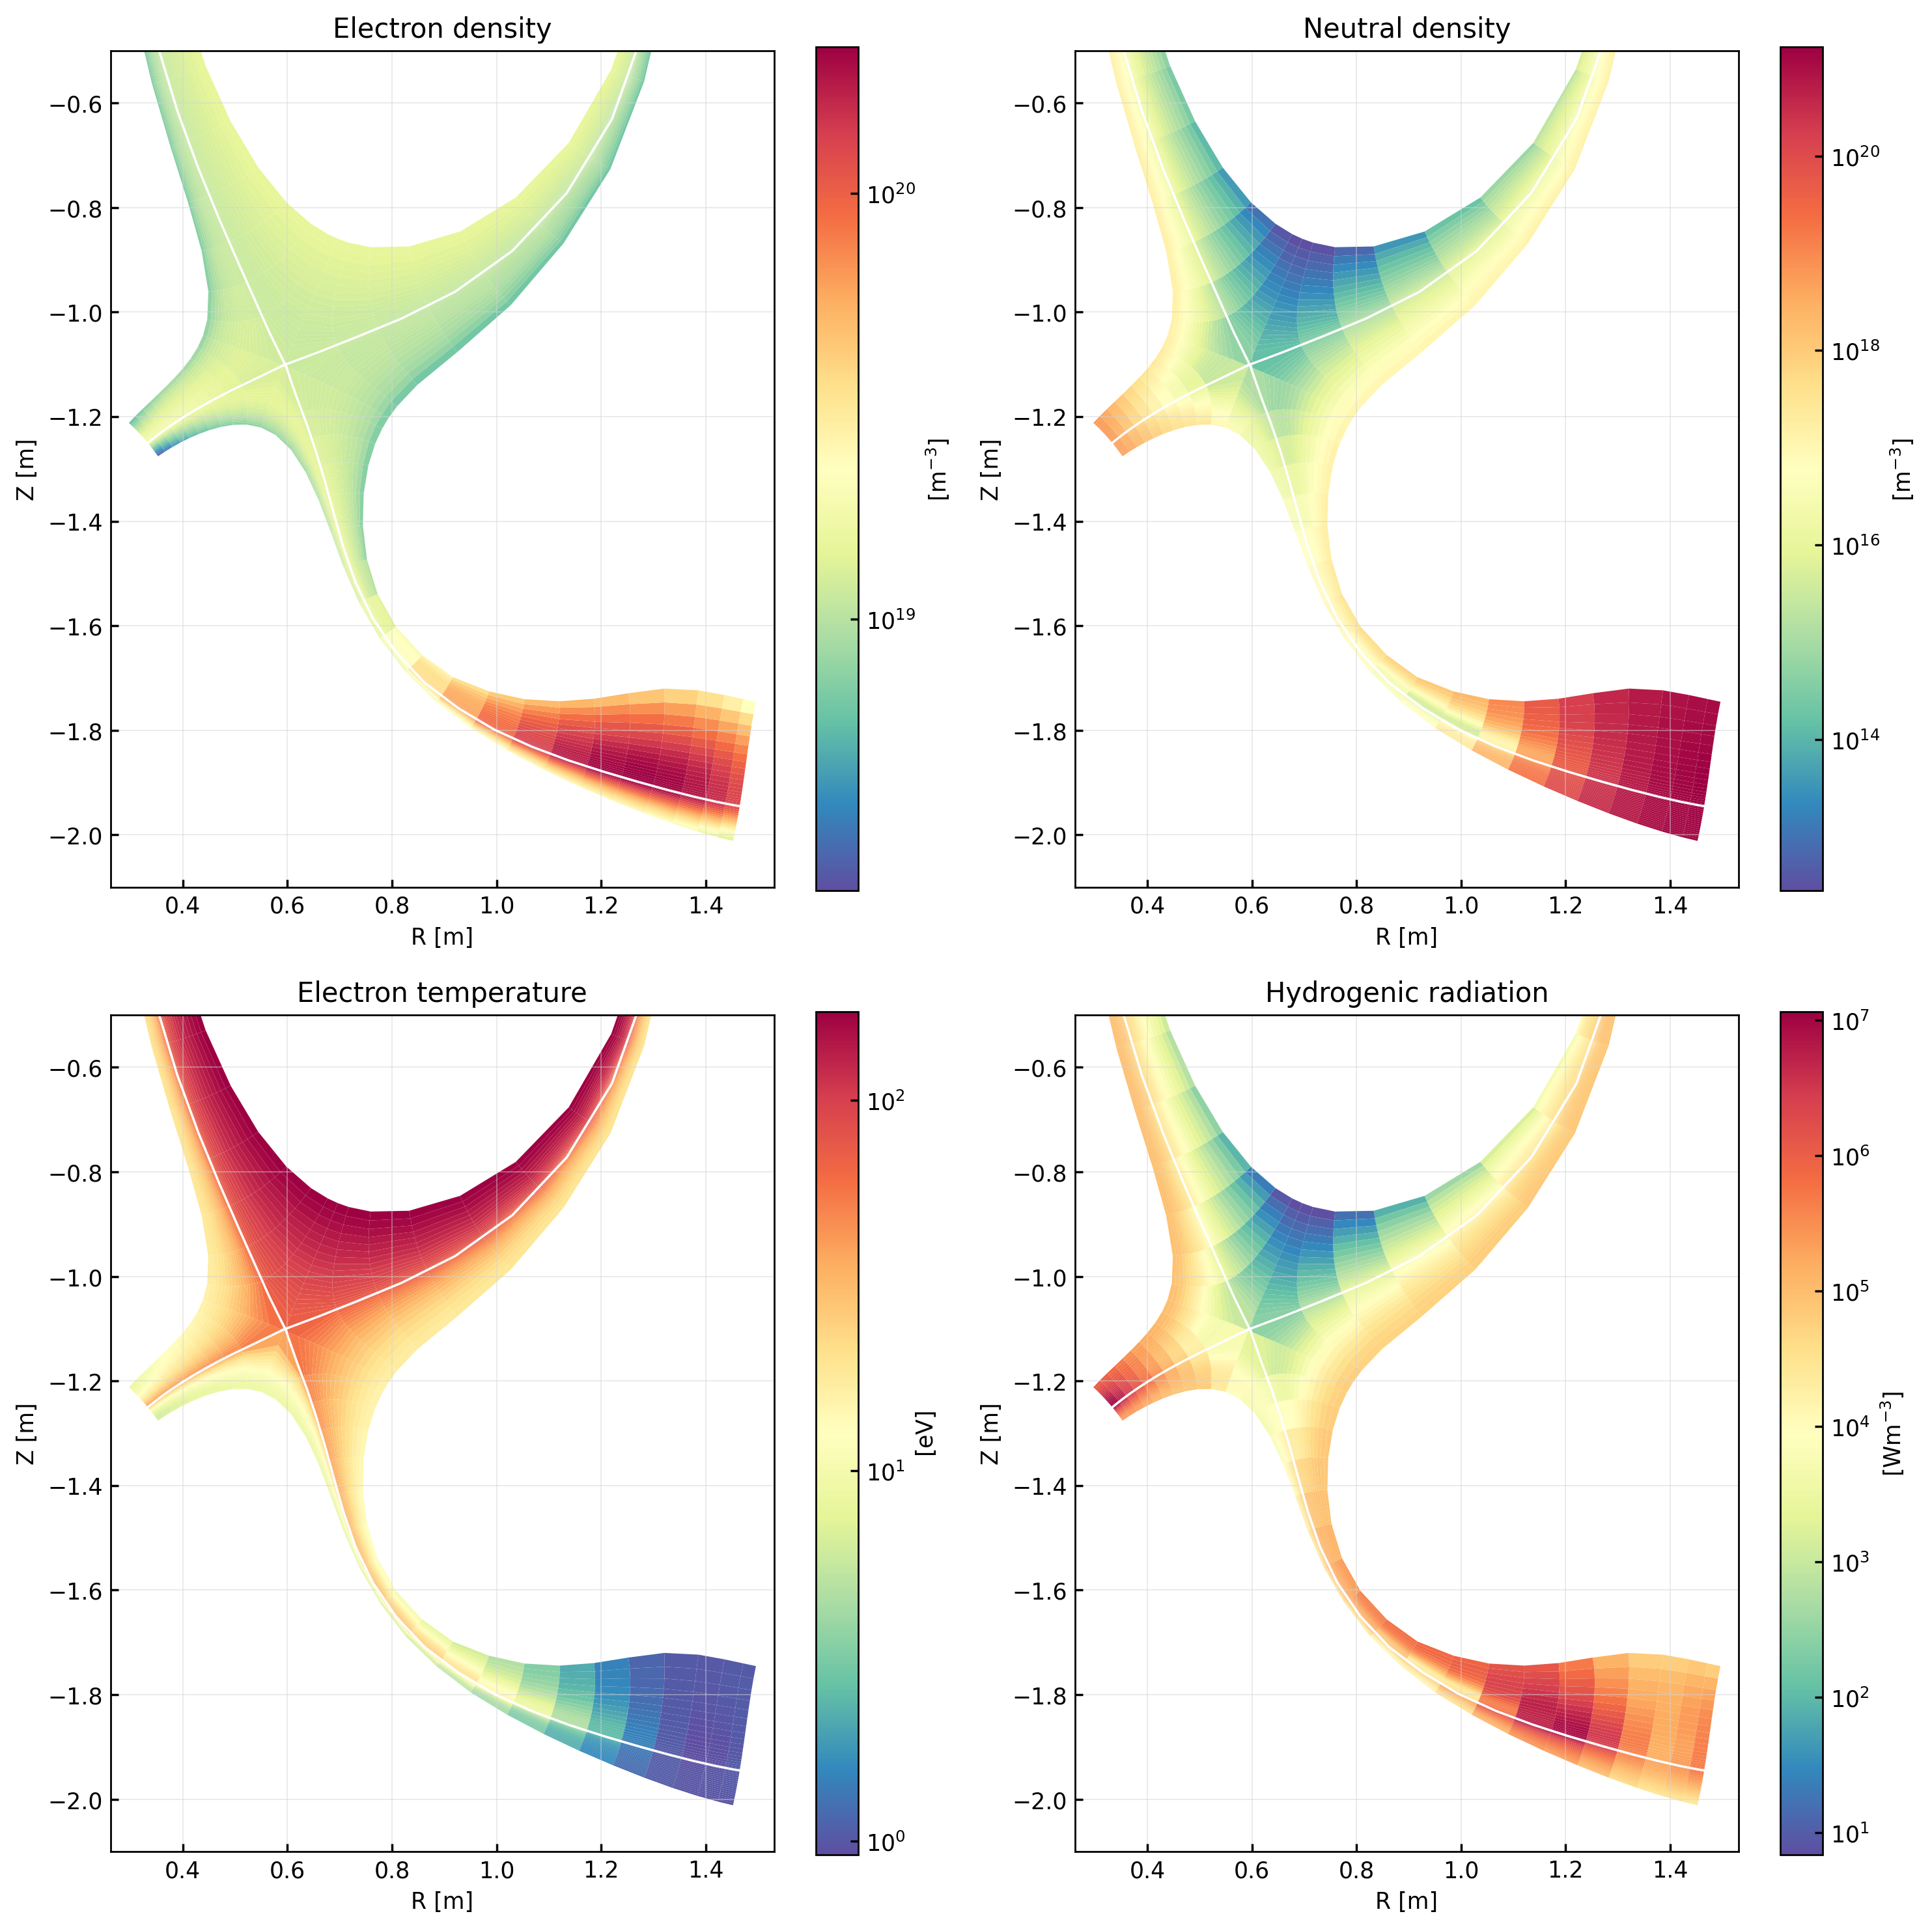

In [23]:
fig, axes = plt.subplots(2,2, figsize = (12,12), dpi = 250)
params = ["Ne", "Nd", "Te", "Rd+_ex"]
titles = ["Electron density", "Neutral density", "Electron temperature", "Hydrogenic radiation"]
labels = ["$[m^{-3}]$", "$[m^{-3}]$", "$[eV]$", "$[Wm^{-3}]$"]

for i, ax in enumerate(axes.flatten()):
    abs(ds[params[i]].hermesm.clean_guards()).bout.polygon(ax = ax, cmap = "Spectral_r", antialias = True, targets = False, 
						separatrix_kwargs = dict(lw = 1, linestyle = "-", color = "white"),
						colorbar_label = labels[i],
						logscale = True)
    
    ax.set_ylim(-2.1, -0.5)
    ax.set_title(titles[i])

fig.tight_layout()

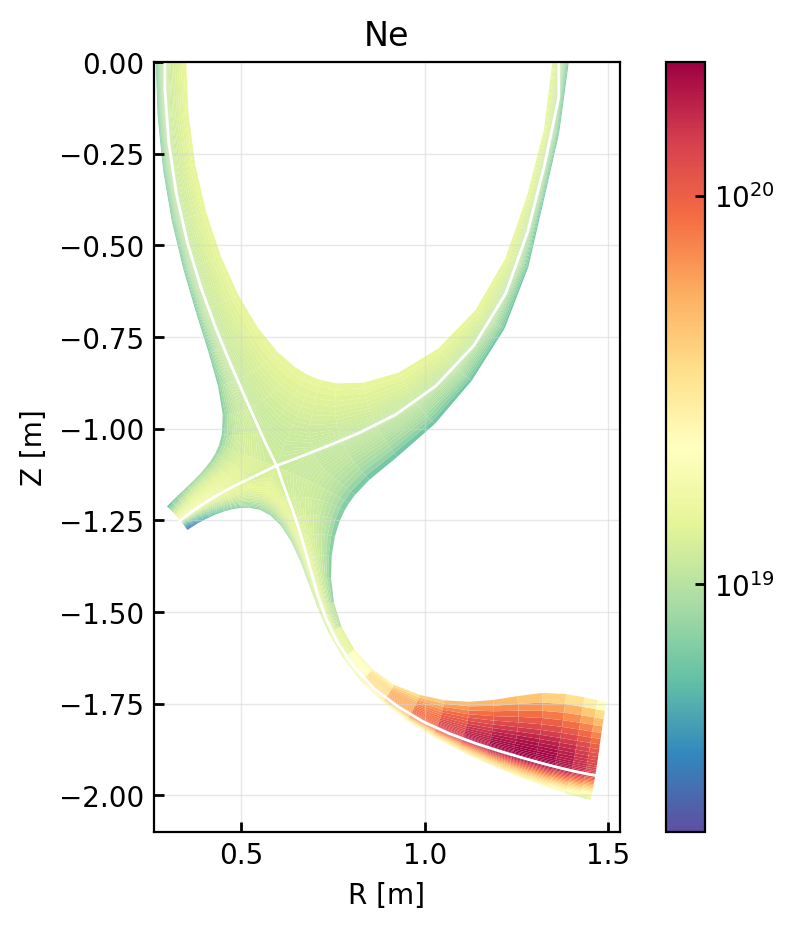

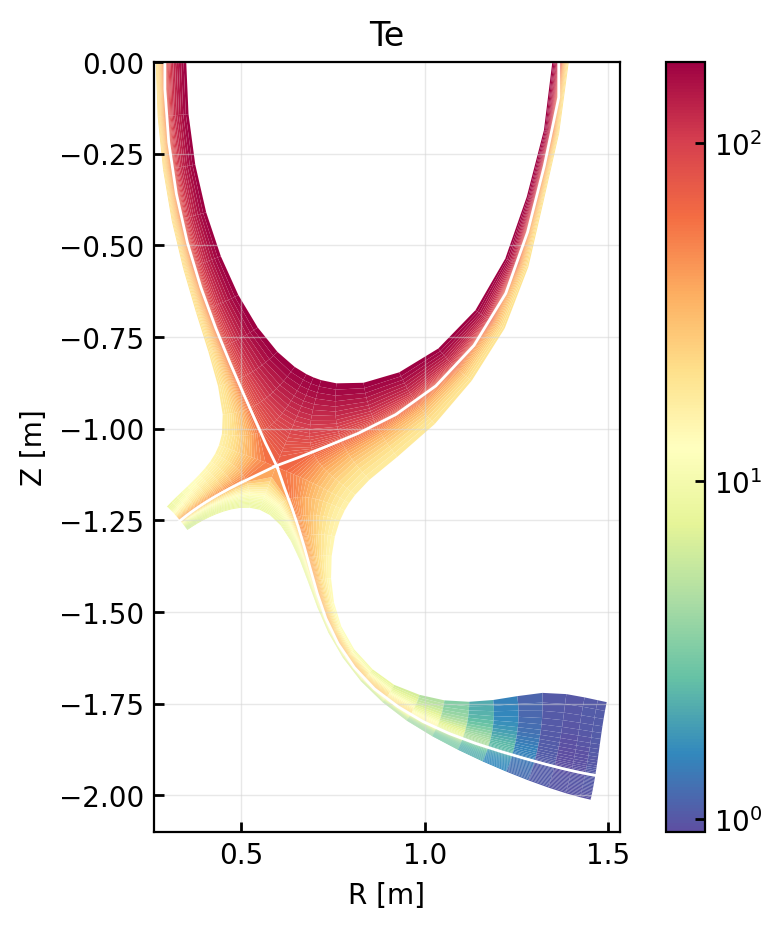

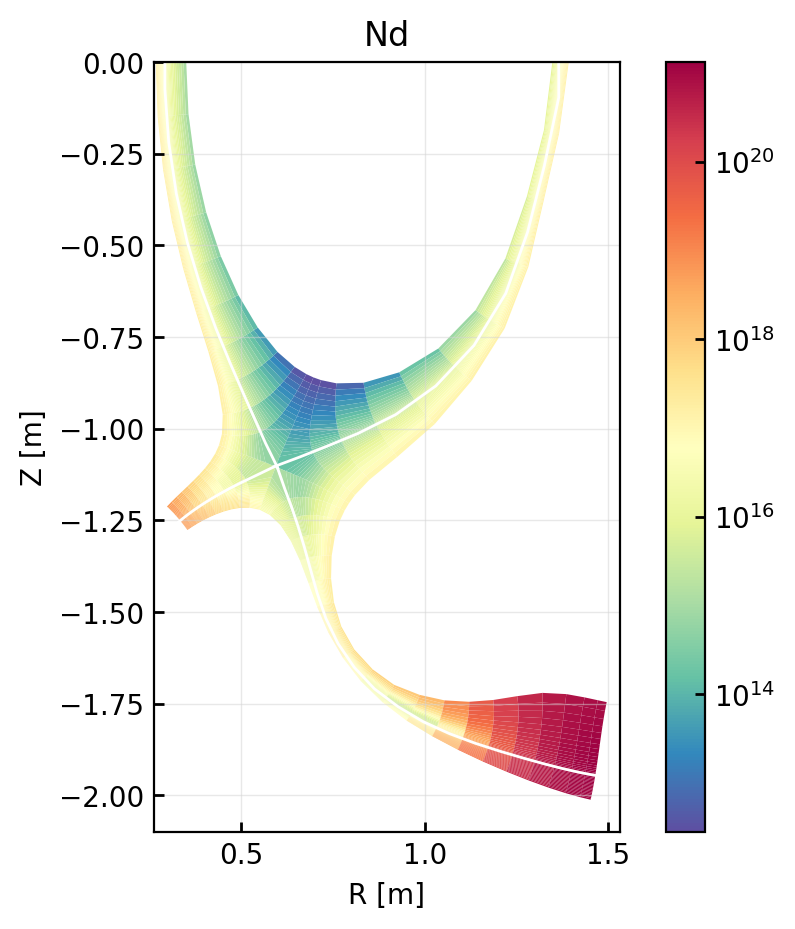

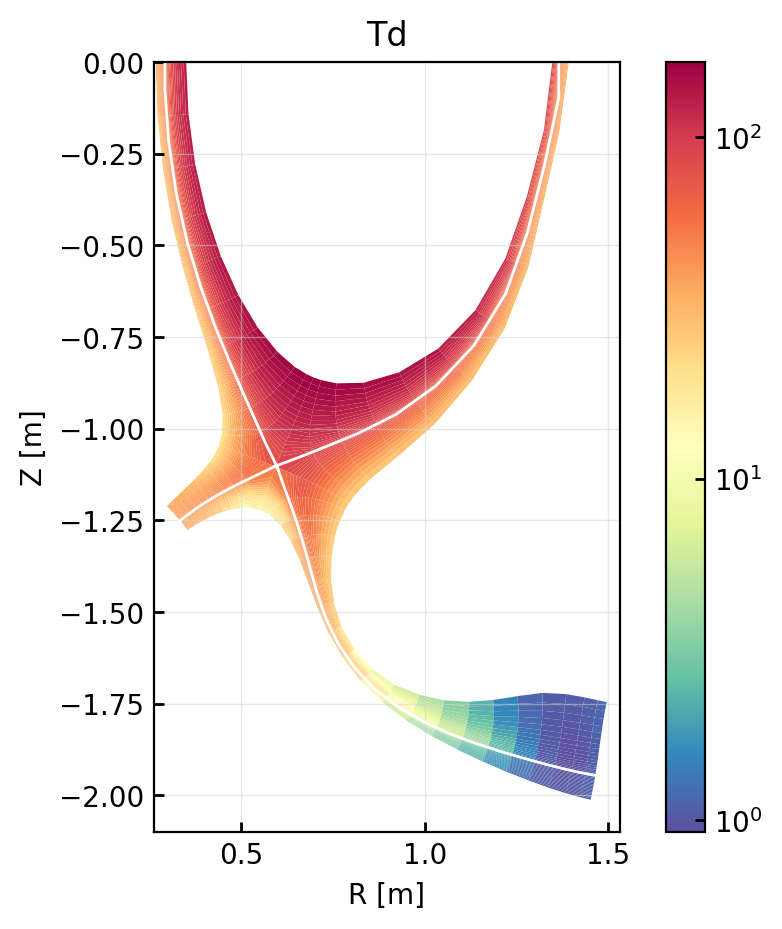

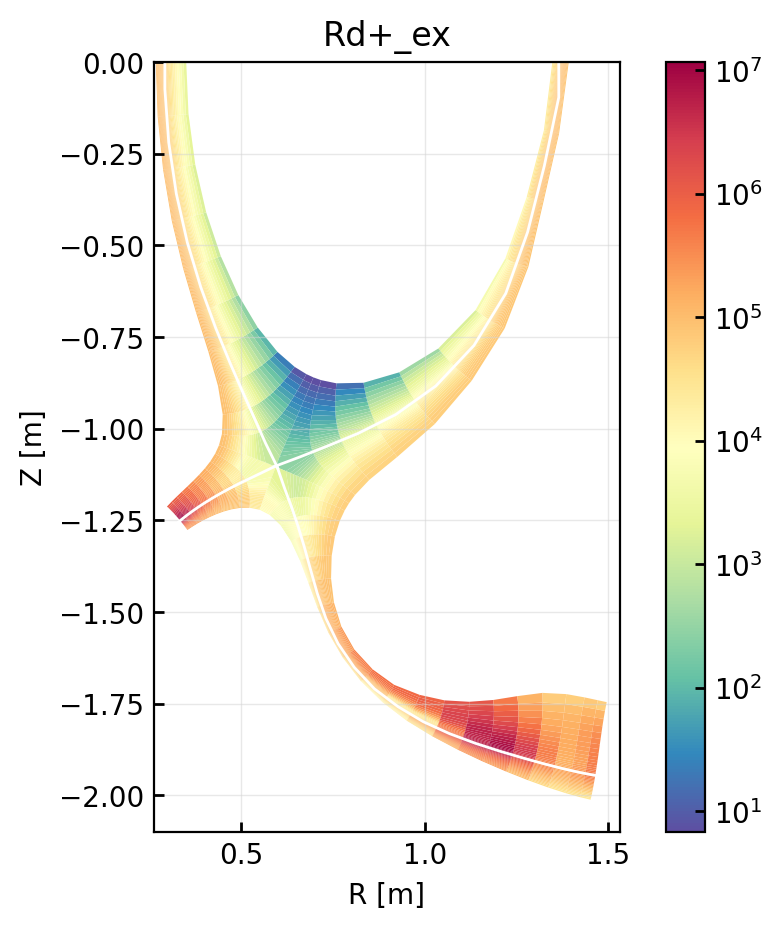

In [13]:
ds = casestore["5e19"].ds.isel(t=-1)
for param in ["Ne", "Te", "Nd", "Td", "Rd+_ex"]:
	fig, ax = plt.subplots(dpi = 200)
	abs(ds[param].hermesm.clean_guards()).bout.polygon(ax = ax, cmap = "Spectral_r", antialias = True, targets = False, 
						separatrix_kwargs = dict(lw = 1, linestyle = "-", color = "white"),
						logscale = True)

	ax.set_ylim(-2.1, 0)

In [4]:
plt.close("all")
%matplotlib inline

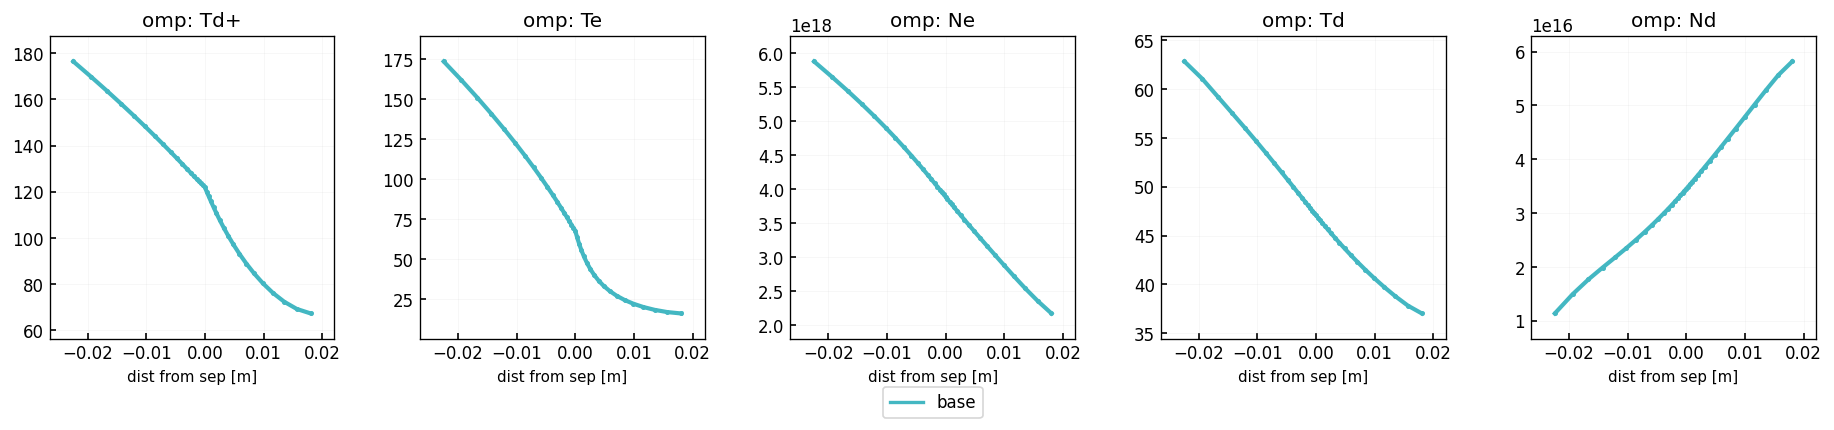

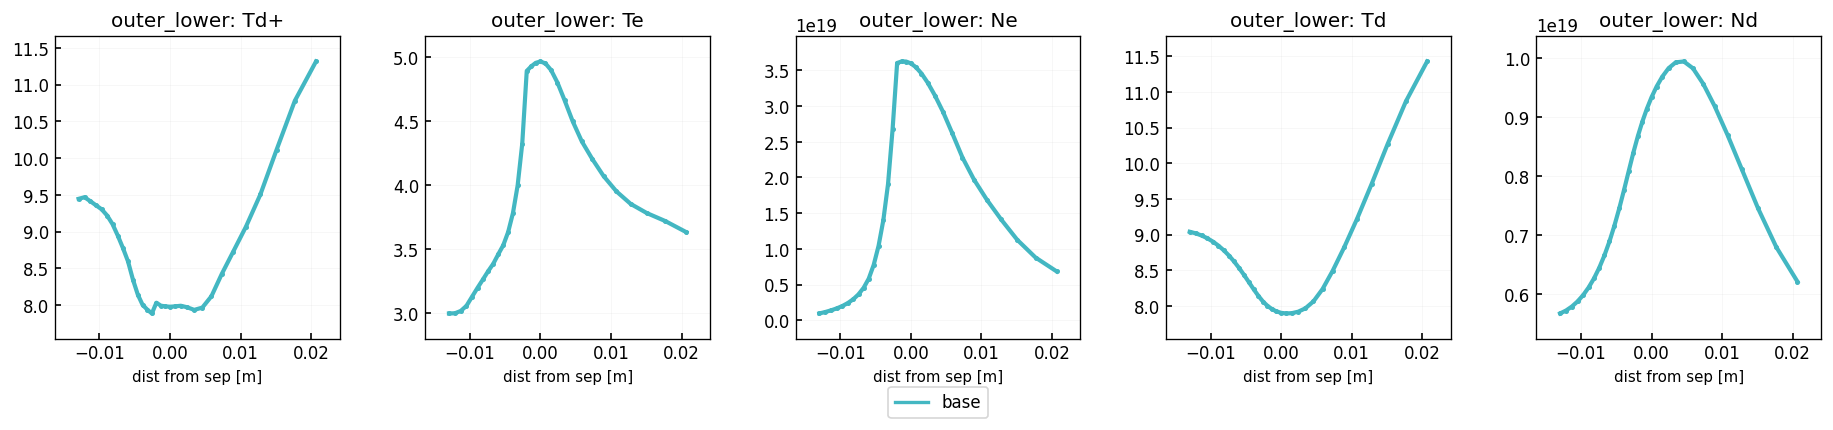

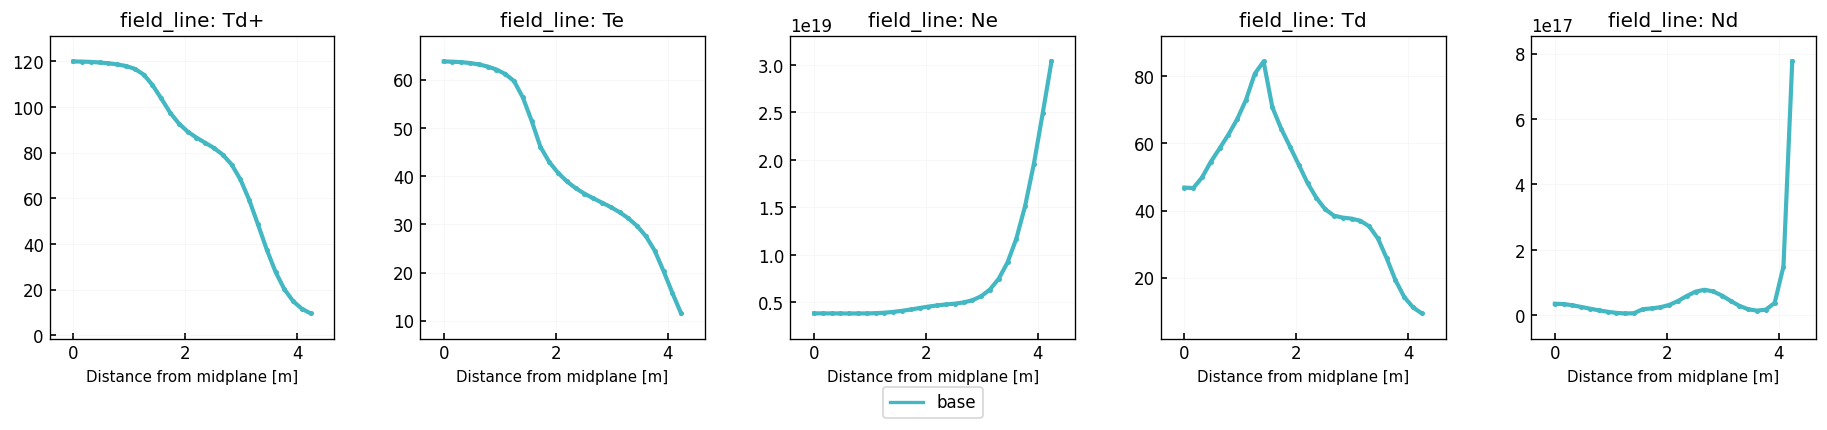

In [19]:

lineplot(
    {
        "base":casestore["base"].ds.isel(t=-1),

    },
    clean_guards = True,
    logscale = False,
    params = ["Td+", "Te", "Ne", "Td", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

## Read Hermes data

In [20]:
hr = dict()
for name in casestore.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(casestore[name].ds.isel(t=-1, x = slice(2,-2)))
    
    if "afnE" in  name:
        new_afn = True
        print(f"Loading {name} with new AFN")
    else:
        new_afn = False
        print(f"Loading {name} with old AFN")
    
    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = new_afn)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

afnE_2e19_fixnbc
Loading afnE_2e19_fixnbc with new AFN


# Read SOLEDGE CSV data

In [6]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

## Read SOLPS

In [34]:
solpscases = {
    # "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    # "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    # "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    # "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    # "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    # "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    # "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    # "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    # "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    # "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
    "tightwall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19",
    "tightwall_noD2_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2",
    
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    # sp[name].read_last10s(solpscases[name])
    sp[name].read_from_case(solpscases[name])

# Simple plots

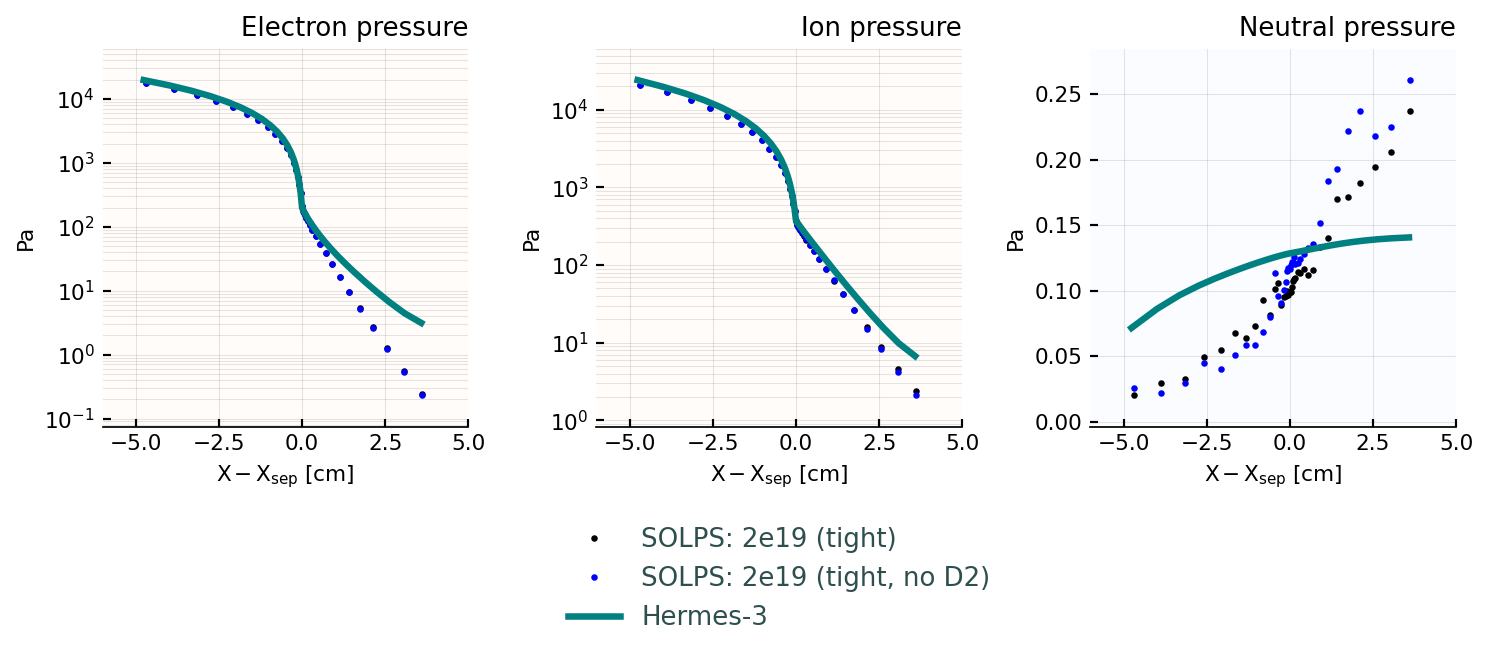

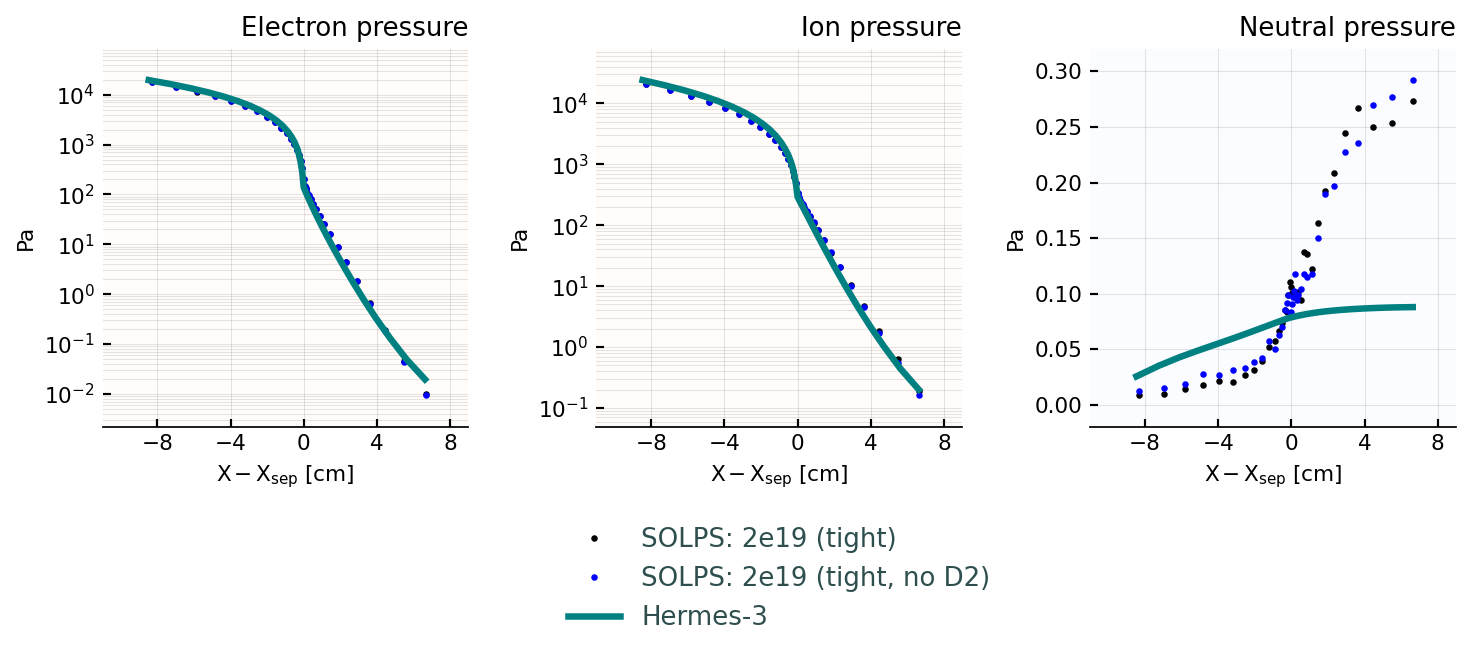

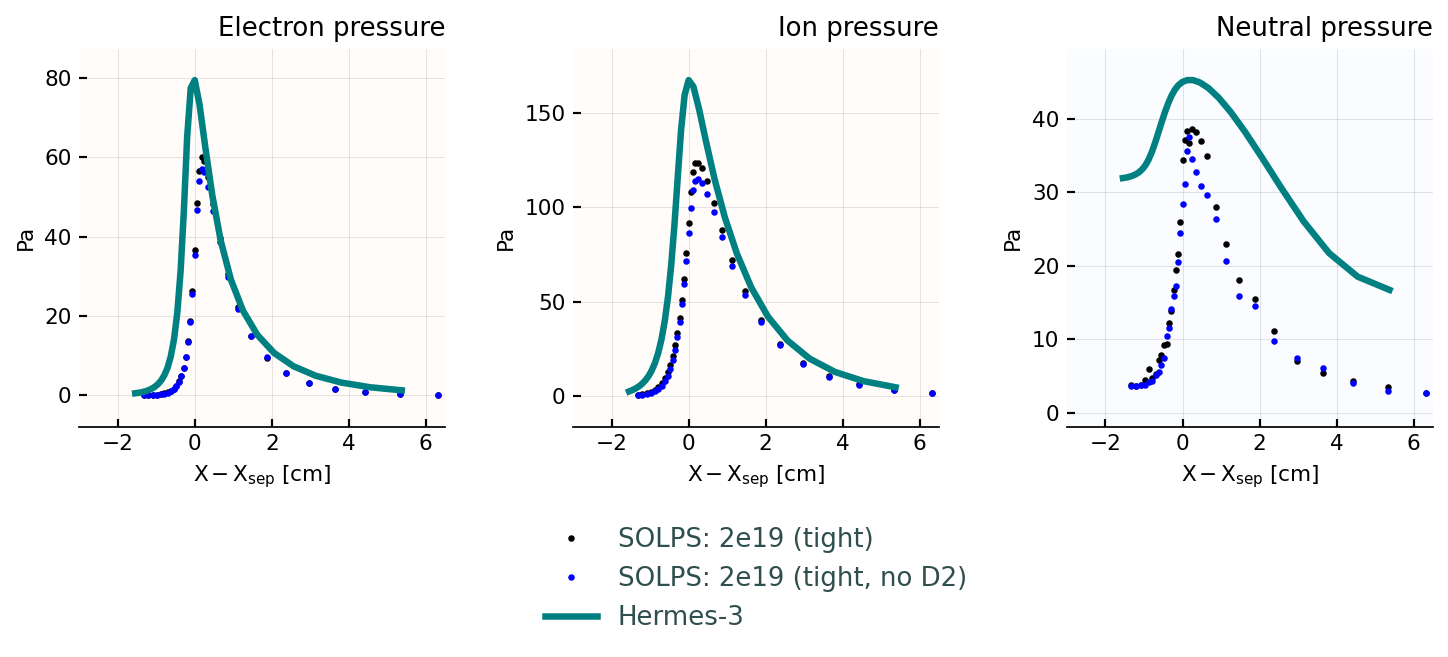

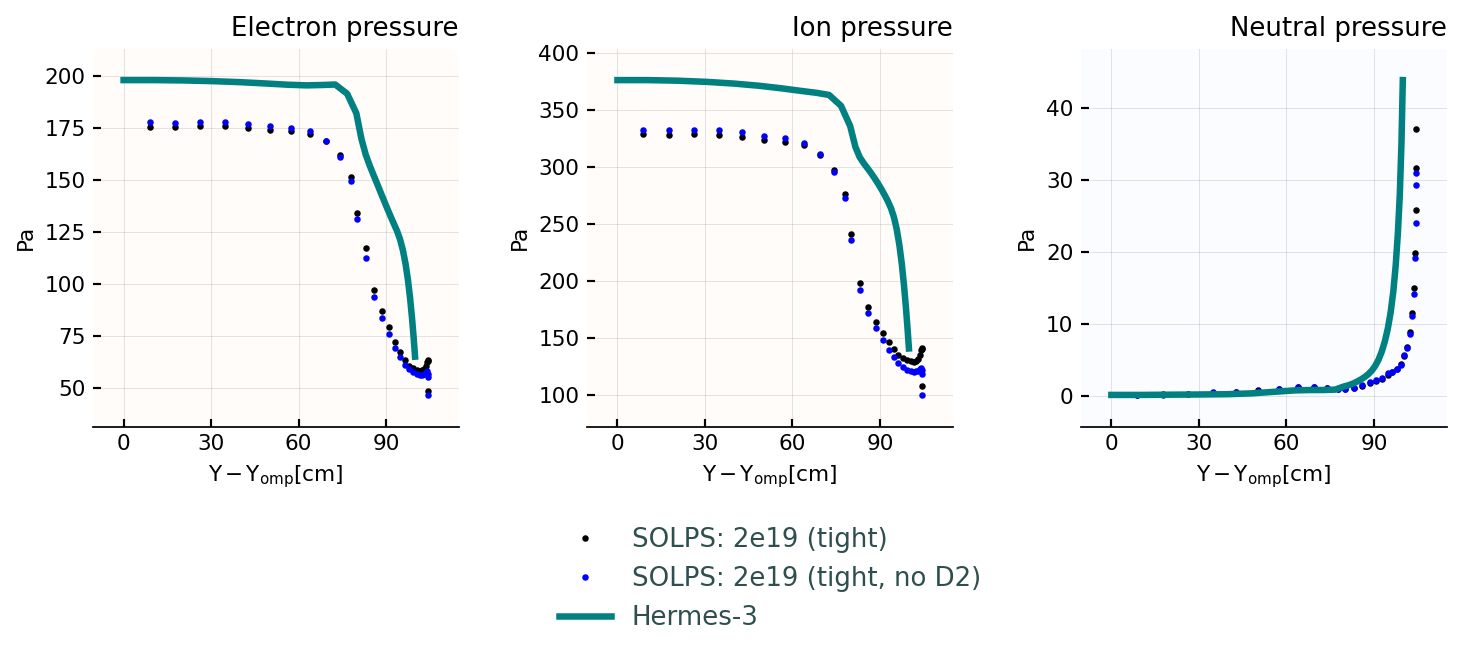

In [35]:

plt.close("all")
lineplot_compare(
    cases = { 


    # "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    "SOLPS: 2e19 (tight)" : dict(data=sp["tightwall_2e19"], color="black"),
    "SOLPS: 2e19 (tight, no D2)" : dict(data=sp["tightwall_noD2_2e19"], color="blue"),
    r"Hermes-3" : dict(data=hr['afnE_2e19_fixnbc'], color = "teal"),
    # r"Hermes-3: fix neutbc" : dict(data=hr['afnE_fixes'], color = "orange"),

    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"], 
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Ne", "Na"],
    params = ["Pe", "Pd+", "Pa"],
    combine_molecules = False,
    mode = "log",
    dpi = 120,
    lw = 2
)

In [10]:
print("\n## BASE")
calculate_simple_heat_balance(casestore["afnE_base"].ds.isel(t=-1))
print("\n## FIXES")
calculate_simple_heat_balance(casestore["afnE_fixes"].ds.isel(t=-1))
print()


## BASE
Wall reflective cooling:
inner_wall  : -0.009 [MW]
outer_wall  : -0.078 [MW]
pfr         : -0.083 [MW]
targets     : -0.038 [MW]
Total       : -0.207 [MW]

Recycling neutral energy source:
Total       : 0.417 [MW]

## FIXES
Wall reflective cooling:
inner_wall  : -0.011 [MW]
outer_wall  : -0.078 [MW]
pfr         : -0.078 [MW]
targets     : -0.064 [MW]
Total       : -0.232 [MW]

Recycling neutral energy source:
Total       : 0.407 [MW]



In [13]:
casestore.keys()

dict_keys(['afnE_base', 'afnE_fixes'])

In [65]:
%matplotlib widget

b2fgmtry loaded from .pkl
b2fgmtry loaded from .pkl


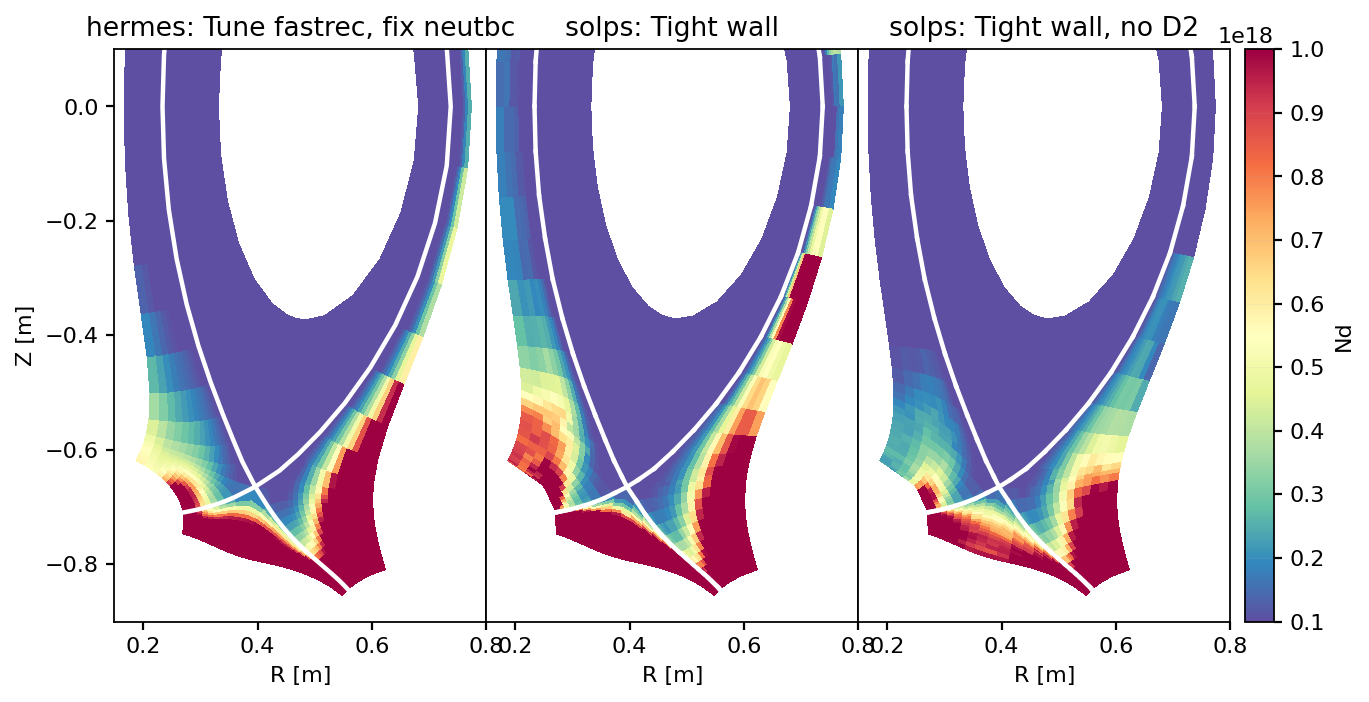

In [26]:
plt.close("all")
v = viewer_2d(
    "Nd",
    [
        # {"name" : "Tight wall", "code":"soledge", "path" : soledgecases["tightwall_3e19"]},
        {"name" : r"Tune fastrec, fix neutbc", "code" : "hermes", "ds" : casestore['afnE_2e19_fixnbc'].ds.isel(t=-1)},
        {"name" : "Tight wall", "code":"solps", "path" : solpscases["tightwall_2e19"]},
        {"name" : "Tight wall, no D2", "code":"solps", "path" : solpscases["tightwall_noD2_2e19"]},
        # {"name" : r"Fix neutbc", "code" : "hermes", "ds" : casestore['afnE_fixes'].ds.isel(t=-1)},
    ],
    logscale = False,
    # vmin = 0,
    # vmax = 100,
    vmin = 1e17,
    vmax = 1e18,
    dpi = 160,
    ylim = (-0.9,0.1),
    xlim = (0.15, 0.8),
    wspace = 0.0,
    cmap = "Spectral_r",
    slider = False,
)